### Distribution Transformation

Distribution transformation is a very useful tool which will be extensively used with the copula concept that we discuss in the next Section.
The technique transforms every random variables from uniform to any distribution and vice versa and is called *probability integral transform* or (*percentile-to-percentile transform*). 

Computationally, this method involves computing the quantile function of the distribution, in other words, computing the cumulative distribution function (CDF) of the distribution (which maps a number in the domain to a probability between 0 and 1) and then inverting that function. We won't go into the details but we will just show few examples of how this can be done in $\tt{python}$.

For example, imagine that $\mathbb{P}(X)$ is the standard normal distribution with mean zero and standard deviation one. If we want to convert uniformly distributed samples to standard normal we need to apply the inverse of CDF to each sample. Below few examples which exploit $\tt{scipy.stats}$ which defines many useful statistical distributions.

(Remember that the Uniform samples have to be interpreted as cumulative probabilities)

In [1]:
# make table uniform to gauss
from scipy.stats import norm

x_unif = [0.3, 0.5, 0.9, 0.99999]

for x in x_unif:
    print ("{:.05f} -> {:.4f}".format(x, norm.ppf(x)))

0.30000 -> -0.5244
0.50000 -> 0.0000
0.90000 -> 1.2816
0.99999 -> 4.2649


The same transformation may be applied directly on the entire sample.

In [2]:
# sample from uniform
from scipy.stats import uniform

x_unif = uniform.rvs(size=10000)

Next we apply $\tt{ppf()}$ to the list of $x$ directly.

In [3]:
# transform to gaus
x_transf = norm.ppf(x_unif)

<img src="uniform_gauss.png">

If we plot them togheter in a 2D plot we can get a sense of what is going on when using the inverse CDF transformation:

<img src="uniform_to_gauss_2d.png">

The inverse CDF stretches the outer regions of the uniform to yield a normal distribution. 

The nice thing of the technique is that it can be used with any arbitrary (univariate) probability distributions, like for example [t-Student](https://en.wikipedia.org/wiki/Student%27s_t-distribution) or [Gumbel](https://en.wikipedia.org/wiki/Gumbel_distribution)

In [4]:
# do the same with t-student
from scipy.stats import t

x_trans2 = t(4).ppf(x_unif)

<img src="uniform_tstudent_2d.png">

Clearly to do the opposite transformation from an arbitray distribution to the uniform(0, 1) we can just apply the inverse of the inverse CDF, which is the CDF itself...

In [ ]:
# make uniform to gauss to uniform
x_trans3 = norm.ppf(x_unif)
x_unif2 = norm.cdf(x_trans3)

<img src="full_chain.png">

## Copula

In probability theory a *copula* $\mathcal{C}(F_1, F_2, \ldots, F_n)$ is a multivariate (multidimensional) cumulative distribution function whose marginal probability distributions (the probability distribution of each dimension) is uniform on the interval $[0, 1]$ ($U_i \approx$ Uniform(0,1)). 

Copulas are used to describe the dependencies between random variables and have been widely used in quantitative finance to model risk. Copulas are popular since they allow to easily model and estimate the distribution of random vectors by representing marginals and their correlation separately. Essentially we can split complicated problems into simpler components so that copula results to be very handy.

### Example Problem Case
Imagine to measure two variables that are correlated. For example, we look at various rivers and for every river we look at its maximum water level, and also count how many months each river caused flooding. 

For the probability distribution of the maximum level of the river we know that maximums are Gumbel distributed, while the number of floods can be modelled according to a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution).

Clearly it is pretty reasonable to assume that the maximum level and the number of floodings is going to be correlated, however we don't know how we could model that correlated probability distribution. Above we only specified the distributions for individual variables, irrespective of the other one (i.e. the marginals), in reality we are dealing with the joint distribution of both of these together. 

And here is where copulas come to our rescue.

Copulas essentially allow to decompose a joint probability distribution into their marginals (which by definition have no correlation) and a function which couples (hence the name) them together and thus allows to specify the correlation separately. 

Copula is that coupling function.

## Adding Correlation with Gaussian Copulas

So let's continue with our example even if we are actually almost done.
Indeed, we saw before how to convert pretty much everything from and to uniform distribution. So that means we can generate uniformly distributed data with the correlation we want and then transform the marginals into the desired distributions. 

How do we do that ? 

* simulate from a multivariate Gaussian with the specific corrrelation structure;
* transform each Gaussian marginal to uniform;
* finally transform the uniforms to whatever we like.

So let's sample from a multivariate normal (2D) with a 0.5 correlation.

In [7]:
# sample from multi-normal with corr
from scipy.stats import multivariate_normal

mvnorm = multivariate_normal(mean=[0,0], cov=[[1, 0.5],
                                             [0.5, 1]])

x = mvnorm.rvs(size=10000)
print (x[0])

[-0.59633354 -0.0749517 ]


<img src="multivariate_2d.png">

Now use what we have just seen to tranform the marginals to uniform using the $\tt{cdf}$ function of the normal distribution ($x$ is a 2D vector in this case, but tranformation will be applied separately on each component)

In [8]:
# convert each component
x_unif = norm.cdf(x)

<table>
    <tr>
        <td><img src="copula_2d.png" width=300></td>
        <td><img src="copula_3d.png" width=300></td>
    </tr>
</table>

These plots above is usually how copulas are visualized. **Since we used a multivariate stadard normal to model correlation this is also called a Gaussian Copula.**

Finally we can just transform the marginals again from uniform to what we want (i.e. Gumbel and Beta in our river example): 

In [9]:
# convert again to gumbel e beta
from scipy.stats import gumbel_l, beta

x1 = gumbel_l.ppf(x_unif[:][0])
x2 = beta(a=3, b=10).ppf(x_unif[:][1])

To see that it is actually working as expected we should now compare our scatter plot with correlation to the joint distribution of the same marginals without correlation:

In [10]:
# sample from Gumbel
# sample from Beta
m1 = gumbel_l.rvs(size=10000)
m2 = beta(a=3, b=10).rvs(size=10000)

<table>
    <tr>
        <td><img src="gumbel_beta_corr.png" width=300></td>
        <td><img src="gumbel_beta_uncorr.png" width=300></td>
    </tr>
</table>

Using the uniform distribution as a common base for our transformations we can easily introduce correlations and flexibly construct complex probability distributions. Clearly this is directly extendeable to higher dimensional distributions as well.

### Generate Correlated Distributions
Let's now see how copulas can be used to generate numbers from correlated distributions. These are the steps to follow:

* generate a random vector $\mathbf{x}=(x_1, x_2,\ldots)$ from a multivariate distribution with the desired correlation;
* determine the single $U_i(x_i)$ by applying $\tt{cdf}$ to each $x_i$;
* transform again each $U_i(x_i)$ to the desired marginal distributions using $\tt{ppf}$.

Each component of the vector $\mathbf{x}$ is now transformed as it was drawn from the desired marginals with the appropriate correlation.

A practical application concerns the probability of default. Imagine there are three companies (A, B and C) which have a cumulative probability of defaulting within the next two years of 10%.

Let’s try to compute the probabilities to have the three of them all defaulting within the next two years in the cases with independent and correlated default probabilities.

In the first case (independent probabilities), the odds to get three defaults within two years is the product of the single probabilities, hence:
$$\mathbb{P}_{\mathrm{uncorr}}= 10\%\cdot 10\%\cdot 10\% = 0.1\%$$

We can verify this in $\tt{python}$ by applying the Monte Carlo algorithm outlined above: generate a random sample from an uncorrelated multivariate normal distribution, then transform each sample
( $[ x_A , x_B , x_C ]$ ) into the uniform distribution with the $\tt{norm.cdf}$ function (i.e. we convert the samples into probabilities) and then count how many times the three of them are lower than 10%. The final probability will be the ratio of the numer of successes by the total trials.

I am not interested in the real distribution of the marginals since I just want to work with cumulative probabilities so the uniforms are sufficients.

In [12]:
# test default probabilities of three companies (no corr)
from scipy.stats import multivariate_normal, norm

mvnorm = multivariate_normal(mean=[0,0,0], cov=[[1, 0, 0],
                                                 [0,1,0],
                                                  [0,0,1]])

trials = 500000
success = 0.0
x = mvnorm.rvs(size=trials)
x_unif = norm.cdf(x)

for i in x_unif:
    if max(i)<0.1:
        success += 1
        
print (success/trials)

0.001022


If we repeat the same Monte Carlo experiment with perfectly correlated default probabilities
we have

In [13]:
# test default probabilities of three companies (perfect corr)
from scipy.stats import multivariate_normal, norm

mvnorm = multivariate_normal(mean=[0,0,0], cov=[[1, 0.99999, 0.99999],
                                                [0.99999, 1, 0.99999],
                                                [0.99999, 0.99999, 1]])

trials = 500000
success = 0.0
x = mvnorm.rvs(size=trials)
x_unif = norm.cdf(x)

for i in x_unif:
    if max(i)<0.1:
        success += 1
        
print (success/trials)

0.099604


In this case the result is 10%, like we had only one single company, indeed being perfectly
correlated either there is no default or three "simultaneous" defaults with 10% probability.

## Modelling Correlation between Risks
In credit derivative valuation and credit risk management, one of the most important issue is the estimate of default probabilities and their correlations. 

Default correlation measures the tendency of two companies to default at about the same time. For this, generally speaking, there are two ways: using historical default data or using mathematical models, like copulas. 

Historical default data has played an important role in the estimation of default probabilities. However, because default events are rare, there is very limited default data available. Moreover, historical data reflects the historical default pattern only and it may not be a proper indicator of the future. This makes the estimation of default probabilities from historical data difficult and inexact. To use this same data to estimate default correlations is even more difficult and more inexact. 

On the other hand mathematical models don't rely on historical default data. So this is the way that is now used to estimate/apply correlations.

## Gaussian Copula Model

While there are several types of copula function models, the first
introduced was the *one-factor Gaussian copula model*. This model has,
above all, the advantage that can be solved semi-analytically.

Consider a portfolio of $N$ bonds and assume that the marginal
probabilities of default are known for each issuer. Define:

* $t_i$, the time of default of the $i^{th}$ company:
* $Q_i(t)$, the cumulative probability that company $i$ will default before time $t$; that is, the probability that $t_i \le t$.

To generate a one-factor model for the $t_i$ we define random
variables $X_i$ $(1\le i \le N)$

$$X_i = a_i M + \sqrt{1-a_i^2}Z_i,\qquad i = 1, 2,\ldots, N$$

where $M$ and the $Z_i$ are independent zero-mean unit-variance  distributions (hence $X_i$ are also distributed with zero-mean and unit standard-deviation) and $-1 \le a_i \lt 1$.

The previous equation defines a correlation structure between the
$X_i$ which are dependent on a single common factor $M$. The $Z_i$ term is usually 
called the idiosyncratic component of default. 
The correlation between $X_i$ and $X_j$ is

$$\mathrm{Corr}(X_i, X_j) = \cfrac{\mathbb{E}[(X_i-\mu_i)(X_j-\mu_j)]}{\sigma_{i}\sigma_{j}} =\mathbb{E}[X_i X_j] = a_i a_j \mathbb{E}[M^2] = a_i a_j
$$
where we just exploit the definition of $X_i$ and its properties.

If $F_i$ is the cumulative distribution function of the $X_i$,
with a percentile to percentile transformation we can map the $X_i$ to the $t_i$, so that $Q_i(t_i) = \mathbb{P}(X_i\le x)=F_i(x)$.
Therefore the point $X_i = x$ is transformed to $t_i = t$ where
$x = F_i^{-1}[Q_i(t)]$.

Let's note that, *conditional* on $M$, the $N$ default events are independent. So we can write

$$
\begin{split}
Q_i(t_i|M) = \mathbb{P}(X_i\le x|M) &= \mathbb{P}(a_i M + \sqrt{1-a_i^2}Z_i\le x|M) =\\
&= \mathbb{P}\left(Z_i\le \cfrac{x-a_i M}{\sqrt{1-a_i^2}}\right)
=H_i\left(\cfrac{F^{-1}[Q(t_i)]-a_i M}{\sqrt{1-a_i^2}}\right)
\end{split}
$$

where $H_i$ is the cumulative distribution function of the $Z_i$.

Although in principle any distribution could be used for $M$ and the
$Z$'s (provided they have zero mean and unit variance), one common
choice is to let them be standard normal distributions (resulting in a
Gaussian copula).
So we can specialize the previous equation as

$$
Q_i(t_i|M) = \Phi\left(\cfrac{\Phi^{-1}[Q(t_i)]-a_i M}{\sqrt{1-a_i^2}}\right)
$$

where $\Phi$ denotes the cumulative distribution function of the standard normal distribution.

If we call $\mathcal{C}(t_1,\ldots,t_N)$ the joint distribution of the default times of the $N$ bonds  in the portfolio then

$$
\mathcal{C}(t_1,\ldots,t_N)=\Phi_{A}(\Phi^{-1}(Q_1(t_1)),\ldots,\Phi^{-1}(Q_N(t_N)))
$$

where $A$ is the correlation matrix of the default probabilities, is the one factor Gaussian copula model (one factor because there is only a random variable, $M$, which determines the correlation between $X_i$).

Clearly different choices of distributions result in different copula models, and in different natures of the default dependence. For example, copulas where the \(M\) have heavy tails generate models where there is a
greater likelihood of a clustering of early defaults for several
companies.

### Standard Market Model

Assume the following two assumptions are made:

* all the companies have the same default intensity (hazard rates), i.e, $\lambda_i = \lambda$ (which means they all have the same default probabilities);
* the pairwise default correlations are the same, i.e $a_i = a$; in other words the contribution of the market 	component $M$ is the same for all the companies and the correlation between any two companies is constant, $\rho = a^2$.

Under these assumptions, given the market situation $M = m$, all the
companies have the same cumulative default probability
$Q_i(t_i|m)=\mathbb{P}(X_i \le x|m)$. 
Moreover, for a given value of the
market component $M$, the defaults are mutually independent for all
the underlying companies. 

## Binomial Distribution

In statistics, the binomial distribution is a discrete probability of independent events, where each event has exactly two possible outcomes. For example, if we toss a coin 10 times and we are interested in how many times it will land on heads, the probability of it lending one, two, three, up to 10 head in a row will form a distribution of probabilities or binomial distribution.

The binomial distribution answers to the question which is the probability of exactly k successes on n repeated trials given that:
 
* the number of observations or trials is fixed;
* each observation or trial is independent. Like in the coin toss, the previous toss doesn’t affect the following;
* the probability of success is exactly the same from one trial to another. Each coin toss has 50% chances to fall in heads or tails.

$$\mathrm{PMF_{binomial}} = \binom{n}{k} p^{k}(1-p)^{n-k}$$

where $\binom{n}{k}$ is the binomial coefficient and is equal to $\frac{n!}{k!(n−k)!}$, $p$ is the probability of an outcome.

In [20]:
# probability of tossing a coin 
from scipy.stats import binom

b = binom(10, 0.5)
print (b.pmf(5))

0.24609375000000025


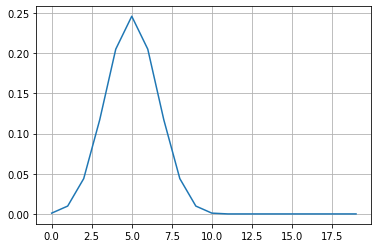

In [23]:
# plot binomial
from matplotlib import pyplot as plt

x = range(20)
plt.plot(x, b.pmf(x))
plt.grid(True)
plt.show()

In [21]:
# probability of head >= 5
s = 0
for i in range(5, 11):
    s += b.pmf(i)
print (s)

0.6230468750000006


In [25]:
# probability of head >= 5 v2

print (1-b.cdf(4))

0.6230468749999999


Letting $l_{t|m}$ be the total defaults that
have occurred by time $t$ conditional on the market condition
$M = m$, then $l_{t|m}$ follows a binomial distribution and

$$Q(l_{t|m} = j) = \cfrac{N!}{j!(N-j)!}Q^j_{t|m}(1-Q_{t|m})^{N-j},\qquad  j=0, 1, 2,\ldots,N$$

In general to evaluate any function of $Q$, $g(Q(l_t))$, regardless the parameter $M$ is necessary to average according to the following integral

$$
g(Q(l_{t} = j)) = \int_{-\infty}^{\infty}{g(Q(l_{t|m} = j))\cdot f_M(m)dm}
$$

where $f_M(m)$ is the probability density function (PDF) of the random
variable $M$ (which with our assumption is a standard normal).

With the assumption that have been made the one factor model is also called *Market Standard Model*.

### Extensions of the One Factor Copula Model
Many other one-factor model have been tried: Student t copula, Clayton copula and many others. In general we can define a new model by simply choosing particular functions for $M$ and $Z_i$ provided they are with mean zero and standard deviation 1. 

If instead of the single factor $M$ there are two or more

$$
X_i = a_1 M_1 + a_2 M_2 + \sqrt{1 - a_1^2 - a^2_2}Z_i
$$
and similarly
$$
Q(t|M_1, M_2) = \Phi\left(\cfrac{\Phi^{-1}[Q(t)]-a_1 M_1 - a_2 M_2}{\sqrt{1 - a_1^2 - a^2_2}}\right)
$$

This kind of models are proportionally slower with the increase of the number of factors.
Later we will also see that the correlation can be determined directly from the market quotes.

## Basket Default Swaps
A basket default swap is a credit derivative on a portfolio of reference
entities. The simplest basket default swaps are first-to-default,
second-to-default, or nth-to-default swaps. 

This kind of contracts are very similar to normal CDS except for the protection they offer.
With respect to a basket of reference entities, a first-to-default swap provides insurance for only the first default, a second-to-default swap provides insurance
for only the second default, and a nth-to-default swap provides insurance for only the $n^{th}$ default. 

For example, in the last case, the
seller does not make a payment to the protection buyer for
the first $n-1$ defaulted reference entities, and makes a payment only for the
$n^{th}$ defaulted reference entity. Once there has been this payment the swap terminates.


### Basket CDS Valuation under Market Standard Model
We now present some numerical results for an $n$th-to-default basket. We assume that the
principals and expected recovery rates are the same for all underlying reference assets.
The valuation procedure is similar to that for a regular CDS where there is only one
reference entity.

In a regular CDS indeed its valuation is based on the probability that a default
occured between times $t_1$ and $t_2$. Here instead the valuation will be based on the probability that the
$n^{th}$ default was between times $t_1$ and $t_2$.

We assume the buyer of protection makes quarterly payments at a specified rate
until the $n^{th}$ default occurs or the end of the life of the contract is reached. 

In the event of the $n^{th}$ default occurring, the seller pays $F\cdot(1-R)$. 
The contract can be valued by calculating the expected present value
of payments and the expected present value of payoffs. 

Let's implement now a class that represents a Basket Default Swap. The idea is to reuse the CreditDefaultSwap class that we have already implemented since for example, computing the NPV of a basket can be considered equivalent to compute the NPV of a CDS using the default probabilities derived by the one factor copula model.

### $\tt{args}$ and $\tt{kwargs}$

$\tt{args}$ and $\tt{kwargs}$ represent two useful ways of passing parameters to a function that is called by another function.

In [27]:
# paramters in global space function of function

a=1
b=2
c=2

def func(x):
    return a*x**2 + b*x + c

def runner(f, x):
    return f(x)*2

print (runner(func, 2))

20


If I had to run many times runner changeing each time the values of the parameters $\tt{a}$, $\tt{b}$ and $\tt{c}$ I would be in troubles. So I can use $\tt{args}$ with the star operator.

In [29]:
# same but with args

def func(x, a, b, c):
    return a*x**2 + b*x + c

def runner(f, x, args):
    return f(x, *args)*2

for v in range(3):
    print (runner(func, 2, args=(v, 2, 2)))

12
20
28


The minimization algorithm is a clear example of this. If you think of $\tt{runner}$ as the $\tt{minimize}$ function and $\tt{func}$ as the objective function the analogy is quite close. In our examples we have always used the first way.

$\tt{kwargs}$ works like $\tt{args}$ except that you have to pass a dictionary with as keys the names of the parameters. Also to expand it you have to use the double-star operator.

In [30]:
# same but kwargs
def func(x, a, b, c):
    return a*x**2 + b*x + c

def runner(f, x, args):
    return f(x, **args)*2

for v in range(3):
    print (runner(func, 2, args={"a":v, "c":2, "b":2}))

12
20
28


Going back to the BasketDefaultSwaps class we will use this technique. In fact the idea is:

* compute the correlated default probability of each name according to 

$$Q(t|M) = \Phi\left(\cfrac{\Phi^{-1}[Q(t)]-\sqrt{\rho} M}{\sqrt{1-\rho}}\right)$$

* compute the probability to have at least j defaults using the binomial distribution

$$Q(l_{t|m} \ge j) = \sum_{k=j}^{N}\left[\cfrac{N!}{k!(N-k)!}Q(t|M)^k(1-Q(t|M))^{N-k}\right]$$

* create a **credit curve**, $CC(Q)$,  with those probabilities;
* re-use the $\tt{CreditDefaultSwap}$ class methods to compute NPV and breakeven rate (which depend on a discount curve and a previous credit curve), through integration of

$$ \mathrm{NPV}(DC, CC(Q)) = \int_{-\infty}^{\infty}{\mathrm{NPV}(DC, CC(Q)) f_M(m)dm} $$
and similarly for the breakeven rate.

Imagine you need to integrate a function $f$ in $\tt{python}$ we can use the $\tt{scipy.integrate.quad}$ function which takes in input, the function to integrate, the integration limits and optional arguments of the integrand.

Imagine to integrate

$$f(x) = \int_{-2}^{4}(ax^{3} + b)~dx$$

for $a=3$ and $b=5$. 

In [32]:
# example of integral
from scipy.integrate import quad

def func(x, a, b):
    return (a*x**3 + b)

i = quad(func, -2, 4, args=(3, 5))
print (i[0])

210.0


In [50]:
# class BasketDefaultSwaps with underlying cds
from finmarkets import CreditCurve, CreditDefaultSwap
from scipy.stats import norm, binom
from numpy import sqrt, exp
from scipy.integrate import quad
import numpy as np

class BasketDefaultSwaps:
    def __init__(self, notional, names, rho, start_date, spread,
                 maturity, tenor=3, recovery=0.4):
        self.names = names
        self.rho = rho
        self.cds = CreditDefaultSwap(notional, start_date, spread, maturity, tenor, recovery)

    def npv(self, Q_dates, Q, dc, ndefaults):
        s = quad(self.one_factor_model, -np.inf, np.inf,
            args=(self.cds.npv, Q_dates, Q, dc, ndefaults))
        return s[0]
    
    def breakeven(self, Q_dates, Q, dc, ndefaults):
        s = quad(self.one_factor_model, -np.inf, np.inf,
            args=(self.cds.breakevenRate, Q_dates, Q, dc, ndefaults))
        return s[0]
    
    def one_factor_model(self, M, f, Q_dates, Q, dc, j):
        DP = norm.cdf((norm.ppf(Q) - sqrt(self.rho)*M)/(sqrt(1-self.rho)))
        b = binom(self.names, DP)
        S = b.cdf(j-1)
        cc = CreditCurve(Q_dates, S)
        
        return f(dc, cc)*norm.pdf(M)

Consider first a 5-year 3rd-to-default CDS on a basket of 10 reference entities in the
situation where the copula correlation is 0.3 and the expected recovery rate, $R$, is $40\%$. The term structure of interest rates
is assumed to be flat at 5%. The default probabilities for the 10 entities are generated by
Poisson processes with constant default intensities (hazard rates), $\lambda_i = 0.01$, so that 

$$Q(t) = 1 - e^{-\lambda t} $$

In [51]:
# test of the class breakeven
from finmarkets import DiscountCurve
from datetime import date
from dateutil.relativedelta import relativedelta
import numpy as np

n_cds = 10
rho = 0.3
l = 0.01
ndefaults = 3
observation_date = date.today()

pillar_dates = [observation_date + relativedelta(years=i) for i in range(6)]
dfs = [1/(1+0.05)**i for i in range(6)]
dc = DiscountCurve(observation_date, pillar_dates, dfs)
Q = [1-np.exp(-(l*t)) for t in range(6)]

basket = BasketDefaultSwaps(1, n_cds, rho, observation_date, 0.01, 5)
print(basket.breakeven(pillar_dates, Q, dc, ndefaults))

0.0017750563139599736


## Collateralized Debt Obligation

A Collateralized Debt Obligation (CDO) is a credit derivative where the issuer, typically investment banks, gather risky assets and repackage them into discrete classes (*tranches*) based on the level of credit risk assumed by the investor. These tranches of securities become the final investment product.

Tranches are named to reflect their risk profile: senior, mezzanine and subordinated/equity and are delimited by the attachment ($L$) and detachment points ($U$), which represent the percentages of the total principal defining their boundaries. 
For example, a 5-10% tranche has an attachment point of 5% and a detachment point of 10%. 

<!----When the accumulated loss of the reference pool is no more than 5% of the total initial notional of the pool, the tranche will not be affected. However, when the loss has exceeded 5%, any further loss will be deducted from the tranche's notional until the detachment point, 10%, is reached.-->

Each of these tranches has a different level of seniority relative to the others in the sense that a senior tranche has coupon
and principal payment priority over a mezzanine tranche, while a mezzanine tranche has
coupon and principal payment priority over an equity tranche. 

Indeed they receive returns using a set of rules known as *waterfall*. Incomes of the portfolio are first used to provide returns to the most senior tranche, then to the next and so on.
So the senior tranches are generally safest because they have the first claim on the collateral, although they'll offer lower coupon rates.

It is important to note
that a CDO only redistributes the total risk associated with the underlying pool of assets
to the priority ordered tranches. It neither reduces nor increases the total risk associated
with the pool.

There are various kind of CDOs:

* in a **Cash CDO** the reference portfolio consists of corporate bonds owned by the CDO issuer. Cash flows from collateral are used to pay principal and interest to investors. If such cash flows prove inadequate, principal and interest is paid to tranches according to their seniority. 

<img src="cdo_structure.png">

* in a **Synthetic CDO** the underlying reference portfolio is no longer a physical portfolio of bonds or loans, instead it is a *fictitious* portfolio consisting of a number of names each with an associated notional amount. The value of a synthetic CDO usually comes from insurance premiums of credit default swaps paid for by investors. The seller assumes the underlying assets will perform while the investor, on the other hand, assumes the underlying assets will default.

### Cash CDO Expected Losses

Consider a Cash CDO with a maturity of 1 year, made of 125 bonds. Each bond pays a coupon of one unit after 1 year and it has not yet defaulted (the recovery rate $R$ is assumed 0). We are interested in the following three tranches: equity ([0, 3] defaults), mezzanine ([4, 6] defaults) and senior ([7, 9] defaults), (note that now tranches are identified through the number of defaults and not percentages of the principal). 

<img src="ex_cdo_1.png">

We also assume that the probability of default within 1 year are identical for each bond ($Q$) and that the correlation between each pair is also identical and equal to $\rho$.

Under these assumptions we are in the position to use the Gaussian Copula Model and the derivation of the expected losses results quite simple.

The probability of having $l$ defaults, conditional to the market parameter $M$ will follow a binomial distribution given by

$$p(l|M) = \binom{N}{l}Q_M^l (1-Q_M)^{N-l}$$

where $N$ is the number of bonds in the portfolio and 

$$Q_M = \Phi\left(\cfrac{\Phi^{-1}(Q)-\sqrt{\rho}M}{\sqrt{1-\rho}}\right)$$
where $\Phi$ is the standard normal CDF and $Q$ the probability of default within 1 year of a single name.

From the definition of each tranche with have that the expected losses are

* $\mathbb{E}_{\textrm{equity loss}}(l, Q_M)=3\cdot p(l\ge 3|M) + \sum_{k=1}^{2}k\cdot p(l=k|M)$
* $\mathbb{E}_{\textrm{mezzanine loss}}(l, Q_M)=3\cdot p(l\ge 6|M) + \sum_{k=1}^{2}k\cdot p(l=k+3|M)$
* $\mathbb{E}_{\textrm{senior loss}}(l, Q_M)=3\cdot p(l\ge 9|M) + \sum_{k=1}^{2}k\cdot p(l=k+6|M)$

Each probability $\mathbb{P}$ can be calculated by integrating the above with respect to $M$

$$ \mathbb{E}_{\mathrm{tranche}} = \int_{-\infty}^{\infty}{\mathbb{E}_{\mathrm{tranche}}(l, Q_M) f_M(m)dm} $$

Let's see the corresponding $\tt{python}$ implementation.
First we import the necessary modules and define the needed constants.

In [ ]:
from scipy.stats import binom, norm 
from scipy.integrate import quad 
import numpy as np

N = 125 
Q = 0.02
C = 1
R = 0
tranches = [[1,3],[4, 6],[7,9]]

The we define a function $\tt{p}$ which implements the expected losses for each tranche.
The function depends on the parameter $\tt{M}$, and takes as inputs the correlation $\tt{rho}$ and the tranche attach-detach limits.

In [ ]:
# one_factor_model class

Finally we loop over a range of possible values for the correlation on each tranche to draw the plot of the expected losses vs the correlation.

In [ ]:
# loop over rho for plot
res = [[], [], []]


<img src="losses_vs_rho.png">

Some considerations can be done from these results. First of all, as expected, the equity tranche is the riskier, producing the highest level of loss. The 

$$
\mathbb{E}_{\textrm{equity loss}}\ge \mathbb{E}_{\textrm{mezzanine loss}} \ge \mathbb{E}_{\textrm{senior loss}}
$$ 

relation holds only if each tranche has the same notional exposure (in our example 3).

Then we can notice that in the equity tranche losses are decreasing in $\rho$. When the correlation is low indeed the probability to have few defaults is higher than that of many. As the correlation increases, there will be more and more "simultaneous" defaults so also other tranches start to suffer losses. In the extreme case of correlation equal to 1 all the tranches are the same (indeed the expected losses curves join together). 

When considering all the tranches covering the entire number of names, the last tranche (the one with detachment point of 100\%) is always increasing in $\rho$. Again this can be explained with the correlated defaults. 
Also, the total expected losses on the three tranches is independent of $\rho$. This is not an accident but it is due to the fact that every default scenario is now categorized in one of the plotted tranches while before this was not the case.

## Synthetic CDO Valuation

Imagine a CDO made of $N$ names in the reference portfolio. The total notional of the protfolio is $F$.
When the $i^{th}$ name defaults, then the portfolio incurs in a loss of $F/N(1-R)$ (the recovery rate is assumed to be fixed for all entities of the portfolio).

The tranche loss function $TL^{L,U}(l)$ for a given time $t$ is a function of the number of defaults $l$ occurred up to that time and is given by

$$TL_{t}^{L,U}=\mathrm{max}(\mathrm{min}(l/N\cdot F(1-R), U)-L, 0)$$

where $l/N\cdot F(1-R)$ is the total portfolio loss, if it is greater than $U$ then the tranche loss is $U$. Conversely if it is lower than $L$ there is no loss.

So for example suppose $L=3\%$ and $U=7\%$ and suppose also that the portfolio loss is $5\%$. Then the tranche loss is 2\% of the total portfolio notional (or 50\% of the tranche notional $=7\%-3\%=4\%$).

When an investor *sells protection* on a tranche she is guaranteeing to reimburse any realized losses on the tranche to the *protection buyer*. To better understand this concept it is useful to think of the protection as an *insurance*. 

In return, the protection seller receives a premium at regular intervals (typically every three months) from the protection buyer.

### Premium Leg
As seen above the premium leg represents the payments that are done periodically by the protection buyer to the protection seller.

These payments are made at the end of each time interval and are proportional to the **remaining notional** in the tranche (this is an important difference with respect to CDS, where the contract ends as soon as a default occurs).

We can then write the NPV of the premium leg as

$$\mathrm{NPV}_{\mathrm{premium}}^{L,U}=S\sum^{n}_{i=1}D(d_i)\cfrac{(d_i - d_{i-1})}{360}\left(F(U-L)-\mathbb{E}[TL_{d-1}^{L,U}]\right)$$
where $n$ is the number of payment dates, $D(d_i)$ is the discount factor, $S$ is the annualized premium. The expected value represents the expected notional remaining in the tranche at time 
$d_{i-1}$.
Note that for simplicity we are ignoring that the default may take place at any time between each payment date.

### Default Leg
The default leg represents the cash flows paid to the protection buyer upon losses occurring in the considered tranche. 

The NPV of the leg can be expressed as
$$\mathrm{NPV}_{\mathrm{default}}^{L,U}=\sum_{i=1}^{n}D(d_i)\left(\mathbb{E}[TL_{d_i}^{L,U}]-\mathbb{E}[TL_{d_{i-1}}^{L,U}]\right)$$
where the argument in parenthesis is the expected losses between time $d_{i-1}$ up to $d_i$. 

Therefore the key ingredient for the valuation of a CDO is the calculation of $\mathbb{E}[TL_{d_i}^{L,U}]$ which appears in both legs.
Using the Gaussian copula it is relatively easy to compute it. 
Indeed we know that 

$$TL_{t}^{L,U}=\mathrm{max}(\mathrm{min}(l/N\cdot F(1-R), U)-L, 0)$$

where the only random variable is the number of defaults $l$. We also know that 

$$\mathbb{E}[TL_{t}^{L,U}] = \sum_{l=0}^{N}TL_{t}^{L,U}\cdot \int_{-\infty}^{\infty} Q(l_{t|M}=j) \phi(M)dM$$

And has we have already seen this calculation can be carried on without too much effort.
The large popularity of the Gaussian copula just resides in this, it allows to compute very quickly very complicated contracts like CDOs which usually involve a large number of correlated names.

### CDO Fair Value
The *fair value* of a CDO tranche is that value of the premium $S^*$ for which the expected value of the premium leg equals the expected value of the default leg and for what we have seen depends on the expected value of the tranche loss function.

$$ S^* = \cfrac{\mathrm{NPV_{default}}^{L,U}}{\sum^{n}_{i=1}D(d_i)\cfrac{(d_i - d_{i-1})}{360}\left(F(U-L)-\mathbb{E}[TL_{d-1}^{L,U}]\right)}$$

This equation defines the CDO fair value, but can also be used to calibrate the implied correlation parameter from the market.
This can be obtained by plugging into the equation the market premium value and solve for the correlation parameter $\rho$.

As usual let's implement a $\tt{python}$ class to represent CDOs.

In [ ]:
from finmarkets_tot import DiscountCurve, CreditCurve, generate_swap_dates
from scipy.integrate import quad
from scipy.stats import norm, binom
import numpy as np
from numpy import exp, sqrt
from datetime import date
from dateutil.relativedelta import relativedelta

class CollDebtObligation:
    def __init__(self, notional, names, tranches, rho, cc,
                 start_date, spreads,
                 maturity, tenor=3, recovery=0.4):
        self.notional = notional
        self.names = names
        self.tranches = tranches
        self.payment_dates = generate_swap_dates(start_date, maturity * 12, tenor)
        self.spreads = spreads
        self.rho = rho
        self.recovery = recovery
        self.cc = cc

    def one_factor_model(self, M, Q, l, L, U):
        P = norm.cdf((norm.ppf(Q) - sqrt(self.rho) * M) / (sqrt(1 - self.rho)))
        b = binom(self.names, P)
        return b.pmf(l) * norm.pdf(M) * max(min(l/self.names * 
                                                self.notional * 
                                                (1 - self.recovery), U) - L, 0)
        
    def expected_tranche_loss(self, d, L, U):
        Q = 1 - self.cc.ndp(d)
        v = 0
        for l in range(self.names+1):
            i = quad(self.one_factor_model, -np.inf, np.inf, 
                     args=(Q, l, L, U))[0]
            v += i
        return v

    def npv_premium(self, tranche, dc):
        L = self.tranches[tranche][0] * self.notional
        U = self.tranches[tranche][1] * self.notional
        v = 0
        for i in range(1, len(self.payment_dates)):
            ds = self.payment_dates[i - 1]
            de = self.payment_dates[i]
            D = dc.df(de)
            ETL = self.expected_tranche_loss(ds, L, U)
            v += D * (de - ds).days / 360 * max((U - L) - ETL, 0)
        return v * self.spreads[tranche]

    def npv_default(self, tranche, dc):
        U = self.tranches[tranche][1] * self.notional
        L = self.tranches[tranche][0] * self.notional
        v = 0
        for i in range(1, len(self.payment_dates)):
            ds = self.payment_dates[i - 1]
            de = self.payment_dates[i]
            ETL1 = self.expected_tranche_loss(ds, L, U)
            ETL2 = self.expected_tranche_loss(de, L, U)
            v += dc.df(de) * (ETL2 - ETL1)
        return v

    def npv(self, tranche, dc):
        return self.npv_default(tranche, dc) - self.npv_premium(tranche, dc)

    def fair_value(self, tranche, dc):
        num = self.npv_default(tranche, dc)
        den = self.npv_premium(tranche, dc) / self.spreads[tranche]
        return num / den

In [ ]:
pillar_dates = []
df = []
observation_date = date.today()

for i in range(2):
    pillar_dates.append(observation_date + relativedelta(years=i))
    df.append(1 / (1 + 0.05) ** i)
dc = DiscountCurve(observation_date, pillar_dates, df)

cc = CreditCurve([observation_date + relativedelta(years=i) for i in range(5)],
                 [1, 0.99, 0.97, 0.95, 0.93])

tranches = [[0.0, 0.03], [0.03, 0.06], [0.06, 0.09], [0.09, 1.0]]
spreads = [0.15, 0.07, 0.03, 0.01]

cdo = CollDebtObligation(100e6, 125, tranches, 0.3, cc,
                         observation_date, spreads, 1, 12)
for i in range(len(tranches)):
    print ("Tranche {} ({}): {:.5f}".format(i, tranches[i], cdo.fair_value(i, dc)))